In [1]:

%pip install matplotlib
%pip install torch
%pip install umap-learn
%pip install tiktoken
%pip install openai
%pip install umap-pytorch
%pip install -U pydantic
%pip install tsne-torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices())

2024-06-18 15:22:36.019431: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 15:22:36.057833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
import warnings

warnings.simplefilter("ignore")

import time

import torch

from tsne_based_rag import TSNE_Based_RAG_Util

from umap_based_rag import UMAP_Based_RAG_Util

from som_based_rag import SOM_Based_RAG_Util

from wiki_datasource import WikiEventsDataSource

from openai_vector_encoder import OpenAIEmbeddingsVectorEncoder

from openai_qa_chatbot import OpenAIQuestionAnswerChatBot

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
openai_key = "Your Key Here"

openai_vector_encoder_id = "text-embedding-ada-002"

openai_encoded_vector_dimensions = 1536

openai_tokenizer_name = "cl100k_base" 

openai_model_name = "gpt-3.5-turbo-instruct"

vector_encoder = OpenAIEmbeddingsVectorEncoder( openai_encoded_vector_dimensions, openai_vector_encoder_id, openai_key )

In [6]:
event_years_to_fetch = [ 2022, 2023, 2024 ]
data_source = WikiEventsDataSource( event_years_to_fetch  )

In [7]:
umap_driven_rag_util = UMAP_Based_RAG_Util( 
                                            vector_encoder = vector_encoder,
                                            n_neighbors = 5,
                                            min_dist = 0.1,
                                            n_components = 2,
                                            k_clusters = 100,
                                            metric = 'cosine',
                                            topk_bmu_for_indexing = 10,
                                            device = device
                                        )

In [8]:
som_driven_rag_util = SOM_Based_RAG_Util( 
                                            vector_encoder = vector_encoder,
                                            som_lattice_height = 20,
                                            som_lattice_width = 30,
                                            learning_rate = 0.3,
                                            topk_bmu_for_indexing = 5,
                                            device = device
                                        )

In [9]:
tsne_driven_rag_util = TSNE_Based_RAG_Util( 
                    vector_encoder = vector_encoder, 
                    n_components = 2,
                    k_clusters = 100,
                    epochs =  300, 
                    perplexity  = 30,
                    metric = "cosine",
                    topk_bmu_for_indexing = 10,
                    vectorize_batch_size  = 100,
                    device = device
                                        )

In [10]:
umap_driven_rag_util.load_n_vectorize_data( data_source )

Vectorized Data Batch:   0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
som_driven_rag_util.load_n_vectorize_data( data_source )

Vectorized Data Batch:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
tsne_driven_rag_util.load_n_vectorize_data( data_source )

Vectorized Data Batch:   0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
umap_driven_rag_util.vectors.shape
som_driven_rag_util.vectors.shape

torch.Size([499, 1536])

SOM-Based Indexed Vectors:   0%|          | 0/499 [00:00<?, ?it/s]

7.755791869999484


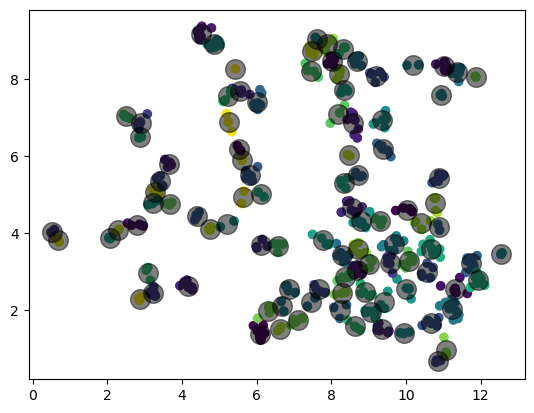

In [14]:
umap_train_t1 = time.perf_counter()
umap_driven_rag_util.train_n_index_data_vectors()
umap_training_time = time.perf_counter() - umap_train_t1
print(umap_training_time)

In [15]:
som_train_t1 = time.perf_counter()
som_driven_rag_util.train_n_index_data_vectors()
som_training_time = time.perf_counter() - som_train_t1
print(som_training_time)

Kohonen's SOM Train Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

data points dimensions torch.Size([499, 1536])  lattice dimensions torch.Size([600, 1536])


SOM-Based Indexed Vectors:   0%|          | 0/499 [00:00<?, ?it/s]

12.774960789000033


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 499 samples in 0.001s...
[t-SNE] Computed neighbors for 499 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 499 / 499
[t-SNE] Mean sigma: 0.239959
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.681732
[t-SNE] KL divergence after 300 iterations: 1.116436


SOM-Based Indexed Vectors:   0%|          | 0/499 [00:00<?, ?it/s]

1.0125124449996292


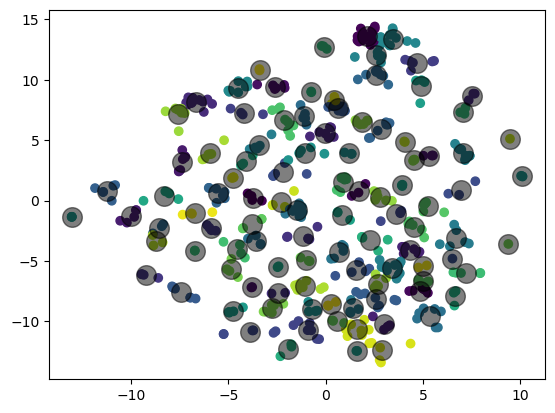

In [16]:
tsne_train_t1 = time.perf_counter()
tsne_driven_rag_util.train_n_index_data_vectors()
tsne_training_time = time.perf_counter() - tsne_train_t1
print(tsne_training_time)

In [17]:
umap_driven_rag_util.find_semantically_similar_data( "Who won the 2024 Sri Lankan Presidential Election?", sim_threshold = 0.7 )

[]

In [18]:
som_driven_rag_util.find_semantically_similar_data( "Who won the 2024 Sri Lankan Presidential Election?", sim_threshold = 0.7 )

[]

In [19]:
umap_openai_chatbot = OpenAIQuestionAnswerChatBot( 
                                                vector_db_util = umap_driven_rag_util,
                                                openai_tokenizer_name = openai_tokenizer_name,
                                                openai_model_name = openai_model_name,
                                                openai_key = openai_key,
                                                question_input_max_token_count = 100,
                                                context_trim_percent = 0.1,
                                                device = device
                                            )

In [20]:
som_openai_chatbot = OpenAIQuestionAnswerChatBot( 
                                                vector_db_util = som_driven_rag_util,
                                                openai_tokenizer_name = openai_tokenizer_name,
                                                openai_model_name = openai_model_name,
                                                openai_key = openai_key,
                                                question_input_max_token_count = 100,
                                                context_trim_percent = 0.1,
                                                device = device
                                            )


In [25]:
tsne_openai_chatbot = OpenAIQuestionAnswerChatBot( 
                                                vector_db_util = tsne_driven_rag_util,
                                                openai_tokenizer_name = openai_tokenizer_name,
                                                openai_model_name = openai_model_name,
                                                openai_key = openai_key,
                                                question_input_max_token_count = 100,
                                                context_trim_percent = 0.1,
                                                device = device
                                            )

In [21]:
sample_questions = [    ["Who won the 2024 Sri Lankan Presidential Election?","Ranil Wickremesinghe"],
                        ["Who won the 2022 soccer world cup?", "Argentina"],
                        ["When did Sweden join NATO?", "2024"],
                        ["Who joined NATO in 2023?", "Finland"],
                        ["Who joined NATO in 2024?", "Sweden"],
                        ["Which is the 31st member of NATO?", "Finland"],
                        ["Which is the 32nd member of NATO?", "Sweden"],
                        ["Who won the Cricket World Cup in 2023?", "Australia"],
                        ["Who defeated India in Cricket World Cup final in 2023?", "Australia"],
                        ["Name the former prime minister of Japan that was assassinated in 2022?", "Shinzo Abe"],
                        ["When did Chandrayaan-3 land near the south pole of the Moon?", "July 14, 2023"],
                        ["Where did Chandrayaan-3 land on the Moon?", "south pole"],
                        ["Who acquired Twitter in 2022?", "Elon Musk"],
                        ["Who owns Twitter?", "Elon Musk"],
                        ["Who acquired Activision Blizzard in 2023?", "Microsoft"],
                        ["What country was invaded by Russia in 2022?", "Ukraine"],
                        ["What year did Russia invade Ukraine?", "2022"],
                   ]

In [22]:
for sample_question in sample_questions:
    print( f"\nQuestion: {sample_question[0]}" )
    answer = umap_openai_chatbot.find_answer_to_question_without_context( sample_question[0] )
    print( f"Answer: {answer}" )


Question: Who won the 2024 Sri Lankan Presidential Election?
Answer: The winner of the 2024 Sri Lankan Presidential Election is currently unknown

Question: Who won the 2022 soccer world cup?
Answer: The 2022 soccer world cup has not yet taken place. It is scheduled

Question: When did Sweden join NATO?
Answer: Negotiations for Sweden to join the North Atlantic Treaty Organization (NATO) have

Question: Who joined NATO in 2023?
Answer: I'm sorry, I do not have information about events that will occur in the

Question: Who joined NATO in 2024?
Answer: I am an AI and I cannot provide an answer to this question. NATO does

Question: Which is the 31st member of NATO?
Answer: There is no designated "31st member" of NATO. As of 202

Question: Which is the 32nd member of NATO?
Answer: North Macedonia.

Question: Who won the Cricket World Cup in 2023?
Answer: The Cricket World Cup is not held annually and it is difficult to predict the winner

Question: Who defeated India in Cricket World Cup

In [23]:
sim_threshold = 0.55
total_time = 0
count = 0
for sample_question in sample_questions:
    print( f"\nQuestion: {sample_question[0]}" )
    t1 = time.perf_counter()
    answer = umap_openai_chatbot.find_answer_to_question( sample_question[0], sim_threshold = sim_threshold)
    t2 = time.perf_counter()
    if sample_question[1] in answer:
        count += 1
    print( f"Answer: {answer}" )
    total_time += (t2-t1)
print(f"Average search time per question {total_time/len(sample_questions)}")
print(f"Accuracy: {count/len(sample_questions)}")


Question: Who won the 2024 Sri Lankan Presidential Election?
Answer: Ranil Wickremesinghe.

Question: Who won the 2022 soccer world cup?
Answer: Argentina won the 2022 FIFA World Cup.

Question: When did Sweden join NATO?
Answer: Sweden joined NATO on March 7, 2024.

Question: Who joined NATO in 2023?
Answer: Finland.

Question: Who joined NATO in 2024?
Answer: Sweden

Question: Which is the 31st member of NATO?
Answer: Finland

Question: Which is the 32nd member of NATO?
Answer: Sweden

Question: Who won the Cricket World Cup in 2023?
Answer: Australia.

Question: Who defeated India in Cricket World Cup final in 2023?
Answer: Australia.

Question: Name the former prime minister of Japan that was assassinated in 2022?
Answer: Shinzo Abe

Question: When did Chandrayaan-3 land near the south pole of the Moon?
Answer: The spacecraft landed near the south pole of the Moon on August 23,

Question: Where did Chandrayaan-3 land on the Moon?
Answer: Near the south pole.

Question: Who acquire

In [24]:
total_time = 0
count = 0
for sample_question in sample_questions:
    print( f"\nQuestion: {sample_question[0]}" )
    t1 = time.perf_counter()
    answer = som_openai_chatbot.find_answer_to_question( sample_question[0], sim_threshold = sim_threshold)
    t2 = time.perf_counter()
    if sample_question[1] in answer:
        count += 1
    print( f"Answer: {answer}" )
    total_time += (t2-t1)
print(f"Average search time per question {total_time/len(sample_questions)}")
print(f"Accuracy: {count/len(sample_questions)}")


Question: Who won the 2024 Sri Lankan Presidential Election?
Answer: The outcome of the 2024 Sri Lankan Presidential Election has yet to be

Question: Who won the 2022 soccer world cup?
Answer: Argentina.

Question: When did Sweden join NATO?
Answer: March 7, 2024

Question: Who joined NATO in 2023?
Answer: Finland

Question: Who joined NATO in 2024?
Answer: Sweden officially joins NATO in 2024.

Question: Which is the 31st member of NATO?
Answer: Finland.

Question: Which is the 32nd member of NATO?
Answer: Sweden

Question: Who won the Cricket World Cup in 2023?
Answer: Australia

Question: Who defeated India in Cricket World Cup final in 2023?
Answer: Australia.

Question: Name the former prime minister of Japan that was assassinated in 2022?
Answer: Shinzo Abe

Question: When did Chandrayaan-3 land near the south pole of the Moon?
Answer: August 23, 2023

Question: Where did Chandrayaan-3 land on the Moon?
Answer: Chandrayaan-3 landed near the south pole of the Moon.

Question: Wh

In [26]:
total_time = 0
count = 0
for sample_question in sample_questions:
    print( f"\nQuestion: {sample_question[0]}" )
    t1 = time.perf_counter()
    answer = tsne_openai_chatbot.find_answer_to_question( sample_question[0], sim_threshold = sim_threshold)
    t2 = time.perf_counter()
    if sample_question[1] in answer:
        count += 1
    print( f"Answer: {answer}" )
    total_time += (t2-t1)
print(f"Average search time per question {total_time/len(sample_questions)}")
print(f"Accuracy: {count/len(sample_questions)}")


Question: Who won the 2024 Sri Lankan Presidential Election?
Answer: Ranil Wickremesinghe won the 2024 Sri Lankan Presidential

Question: Who won the 2022 soccer world cup?
Answer: Argentina.

Question: When did Sweden join NATO?
Answer: March 7, 2024

Question: Who joined NATO in 2023?
Answer: Finland

Question: Who joined NATO in 2024?
Answer: Sweden joined NATO in 2024.

Question: Which is the 31st member of NATO?
Answer: Finland

Question: Which is the 32nd member of NATO?
Answer: Sweden

Question: Who won the Cricket World Cup in 2023?
Answer: Australia

Question: Who defeated India in Cricket World Cup final in 2023?
Answer: Australia.

Question: Name the former prime minister of Japan that was assassinated in 2022?
Answer: Shinzo Abe

Question: When did Chandrayaan-3 land near the south pole of the Moon?
Answer: August 23, 2023

Question: Where did Chandrayaan-3 land on the Moon?
Answer: Near the south pole of the Moon.

Question: Who acquired Twitter in 2022?
Answer: Elon Musk